In [74]:
import os
import json
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from datasets import load_dataset
from pathlib import Path

sns.set_style('whitegrid')
# Increase font sizes for readability
sns.set_context('notebook', font_scale=1.4)
plt.rcParams.update({
    'figure.figsize': (18, 8),
    'font.size': 32,
    'axes.titlesize': 28,
    'axes.labelsize': 25,
    'xtick.labelsize': 23,
    'ytick.labelsize': 23,
    'legend.fontsize': 21
})

## Load MusicCaps dataset

In [75]:
ds = load_dataset("google/MusicCaps")
df_train = ds['train'].to_pandas()
df_train['aspect_list_transformed'] = df_train['aspect_list'].apply(ast.literal_eval)

### Analyse tag counts for concept extraction

In [76]:
tag_counts = {}
for aspects in df_train['aspect_list_transformed']:
    for tag in aspects:
        if tag in tag_counts:
            tag_counts[tag] += 1
        else:
            tag_counts[tag] = 1
tag_counts_df = pd.DataFrame(list(tag_counts.items()), columns=['Tag', 'Count'])
tag_counts_df = tag_counts_df.sort_values(by='Count', ascending=False)

/tmp/ipykernel_20501/2923160130.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')


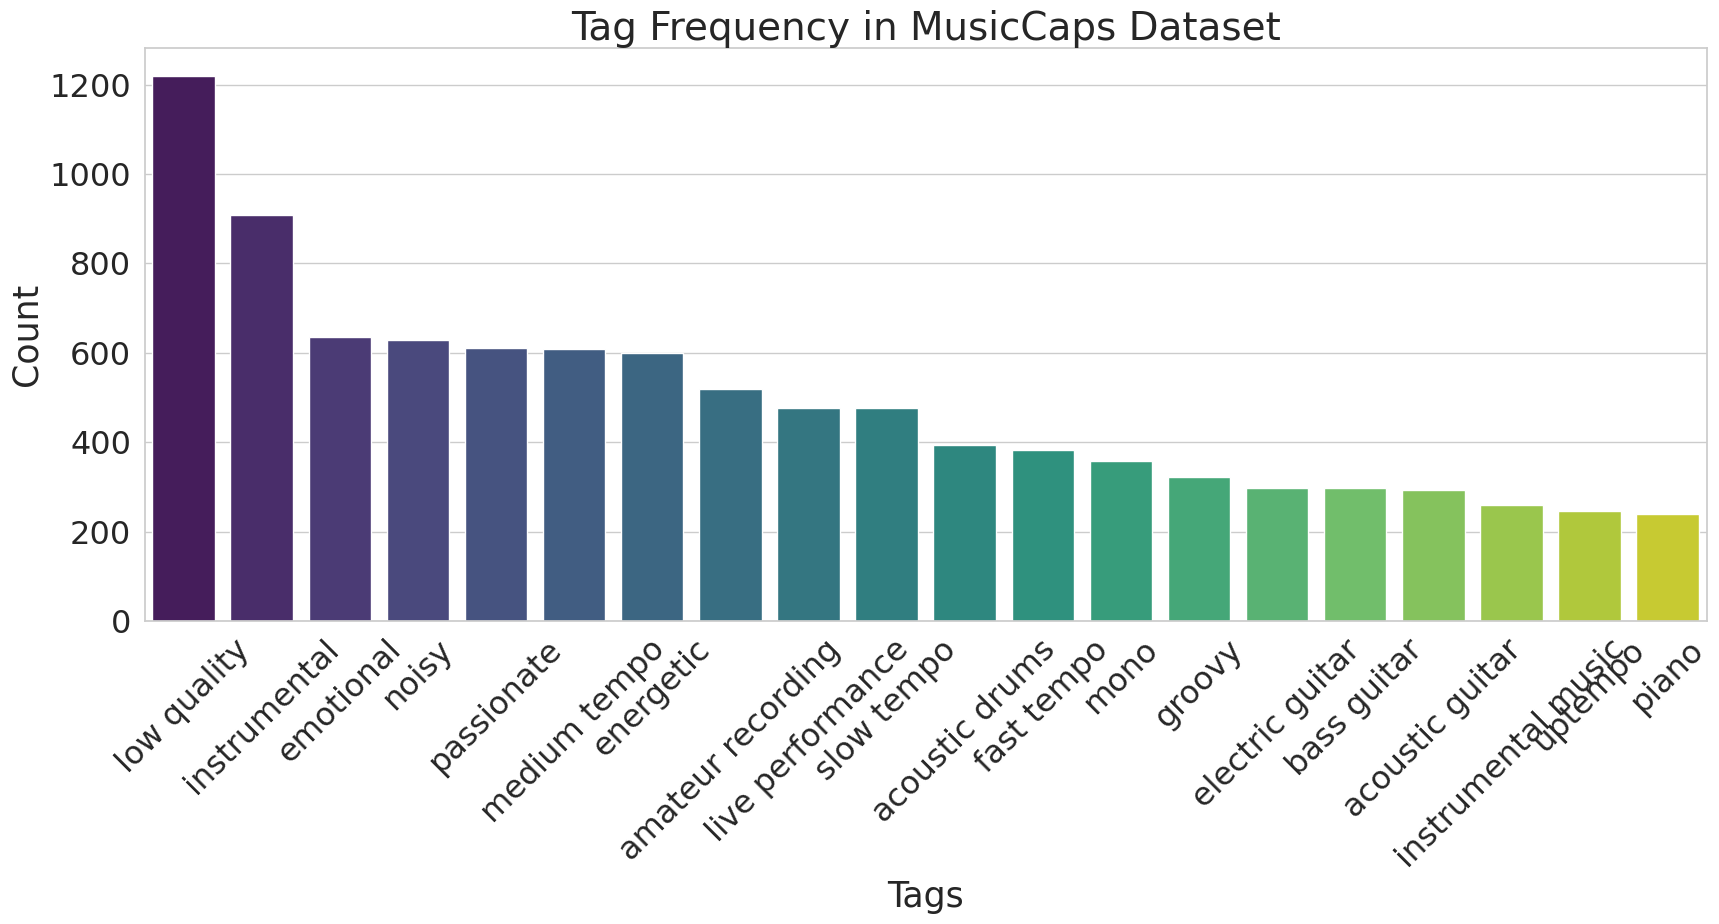

In [77]:
_tag_counts_df = tag_counts_df.head(20)
plt.figure(figsize=(18, 10))
sns.barplot(data=_tag_counts_df, x='Tag', y='Count', palette='viridis')
plt.xticks(rotation=45)
plt.title('Tag Frequency in MusicCaps Dataset')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [78]:
tag_counts_df.to_csv("../data/musiccaps_tag_frequencies.csv", index=False)

## Prepare concept dataset

In [79]:
def extract_tags(song_tags, concept_tags):
    res = []
    for c_tag in concept_tags:
        for s_tag in song_tags:
            if c_tag == s_tag:
                res.append(s_tag)
    return list(set(res))

In [80]:
concepts = json.load(open("../data/concepts_to_tags.json", "r"))

In [81]:
# remove 'low quality' from captions
df_train['caption'] = df_train['caption'].str.replace('low quality', '', case=False)

In [82]:
for concept, tags in concepts.items():
    df_train[concept + '_tags'] = df_train['aspect_list_transformed'].apply(
        lambda x: extract_tags(x, tags)
    )
df_train

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval,aspect_list_transformed,tempo_tags,genre_tags,mood_tags,instrument_tags
0,-0Gj8-vB1q4,30,40,"/m/0140xf,/m/02cjck,/m/04rlf","['low quality', 'sustained strings melody', 's...",The recording features a ballad song that con...,4,False,True,"[low quality, sustained strings melody, soft f...",[],"[soulful, ballad]",[sad],[]
1,-0SdAVK79lg,30,40,"/m/0155w,/m/01lyv,/m/0342h,/m/042v_gx,/m/04rlf...","['guitar song', 'piano backing', 'simple percu...",This song features an electric guitar as the m...,0,False,False,"[guitar song, piano backing, simple percussion...",[slow tempo],[],[],"[no voice, bass]"
2,-0vPFx-wRRI,30,40,"/m/025_jnm,/m/04rlf","['amateur recording', 'finger snipping', 'male...",a male voice is singing a melody with changing...,6,False,True,"[amateur recording, finger snipping, male mid ...",[],[],[],[]
3,-0xzrMun0Rs,30,40,"/m/01g90h,/m/04rlf","['backing track', 'jazzy', 'digital drums', 'p...",This song contains digital drums playing a sim...,6,False,True,"[backing track, jazzy, digital drums, piano, e...",[medium tempo],[],[],"[piano, e-bass, acoustic guitar, digital drums]"
4,-1LrH01Ei1w,30,40,"/m/02p0sh1,/m/04rlf","['rubab instrument', 'repetitive melody on dif...",This song features a rubber instrument being p...,0,False,False,"[rubab instrument, repetitive melody on differ...",[fast tempo],[],[],[no voice]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5516,zw5dkiklbhE,15,25,"/m/01sm1g,/m/0l14md","['amateur recording', 'percussion', 'wooden bo...",This audio contains someone playing a wooden b...,6,False,False,"[amateur recording, percussion, wooden bongo c...",[],[],[],[percussion]
5517,zwfo7wnXdjs,30,40,"/m/02p0sh1,/m/04rlf,/m/06j64v","['instrumental music', 'arabic music', 'genera...",The song is an instrumental. The song is mediu...,1,True,True,"[instrumental music, arabic music, generationa...",[medium tempo],[folk music],"[emotional, passionate]",[]
5518,zx_vcwOsDO4,50,60,"/m/01glhc,/m/02sgy,/m/0342h,/m/03lty,/m/04rlf,...","['instrumental', 'no voice', 'electric guitar'...",The rock music is purely instrumental and feat...,2,True,True,"[instrumental, no voice, electric guitar, dist...",[],[],[],"[no voice, electric guitar]"
5519,zyXa2tdBTGc,30,40,"/m/04rlf,/t/dd00034","['instrumental music', 'gospel music', 'strong...",The song is an instrumental. The song is slow ...,1,False,False,"[instrumental music, gospel music, strong bass...","[slow tempo, groovy rhythm]",[],"[poignant, emotional, passionate]","[keyboard accompaniment, steady drumming rhyth..."


In [83]:
# select rows with tags in at least 3 categories
def count_nonempty_tags(row):
    count = 0
    for col in ['tempo_tags', 'genre_tags', 'mood_tags', 'instrument_tags']:
        if row[col]:
            count += 1
    return count
df_train = df_train[df_train.apply(count_nonempty_tags, axis=1) >= 3]
df_train.reset_index(drop=True, inplace=True)
df_train

,ytid,start_s,end_s,audioset_positive_labels,aspect_list,caption,author_id,is_balanced_subset,is_audioset_eval,aspect_list_transformed,tempo_tags,genre_tags,mood_tags,instrument_tags
0,-1UWSisR2zo,30,40,"/m/04rlf,/m/0xzly","['live performance', 'poor audio quality', 'am...",A male singer sings this groovy melody. The so...,1,False,True,"[live performance, poor audio quality, ambient...",[medium tempo],[ambient noises],[],"[keyboard accompaniment, groovy bass line, mal..."
1,-4NLarMj4xU,30,40,"/m/04rlf,/t/dd00034","['pop', 'tinny wide hi hats', 'mellow piano me...",The Pop song features a soft female vocal sing...,4,False,False,"[pop, tinny wide hi hats, mellow piano melody,...",[],[pop],"[sad, emotional, passionate]","[punchy kick, claps]"
2,-5f6hjZf9Yw,30,40,"/m/02w4v,/m/04rlf","['folk music', 'rubab', 'male voice', 'slow te...",This folk song features a male voice singing t...,0,False,False,"[folk music, rubab, male voice, slow tempo, em...",[slow tempo],[folk music],[],"[male voice, violin]"
3,-6HBGg1cAI0,30,40,"/m/02p0sh1,/m/04rlf,/m/06j64v","['folk song', 'traditional song', 'middle east...",This middle eastern folk song features a male ...,0,False,True,"[folk song, traditional song, middle eastern s...",[moderate tempo],[folk song],[],[male voice]
4,-6pcgdLfb_A,110,120,"/m/04rlf,/t/dd00035","['r&b', 'soul', 'male vocal', 'melodic singing...",This is an R&B/soul music piece. There is a ma...,9,False,False,"[r&b, soul, male vocal, melodic singing, strin...",[groovy],"[soul, r&b]",[sensual],"[electronic drums, male vocal]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,zixIuxzCCvs,30,40,"/m/04rlf,/m/07rwj3x","['heavy metal', 'live performance', 'male voca...",This is the live recording of a heavy metal mu...,9,True,True,"[heavy metal, live performance, male vocal, po...",[fast tempo],[],"[energetic, heavy metal]","[bass guitar, electric guitar, male vocal]"
1886,zkYXE0-JsY4,30,40,"/m/04rlf,/t/dd00035","['four on the floor', 'slow tempo', 'rock', 'm...",This is a hard rock clip with a metallic elect...,3,False,False,"[four on the floor, slow tempo, rock, metallic...",[slow tempo],[rock],[hard rock],[]
1887,zmbwvsdXlBU,30,40,"/m/04rlf,/t/dd00035","['dance song', 'club song', 'whistling sound',...",This dance song features a female voice singin...,0,False,False,"[dance song, club song, whistling sound, techn...",[moderate tempo],[dance song],[happy mood],"[female voice, bass]"
1888,zwfo7wnXdjs,30,40,"/m/02p0sh1,/m/04rlf,/m/06j64v","['instrumental music', 'arabic music', 'genera...",The song is an instrumental. The song is mediu...,1,True,True,"[instrumental music, arabic music, generationa...",[medium tempo],[folk music],"[emotional, passionate]",[]


In [84]:
df_train = df_train[["caption", "aspect_list_transformed", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train["combined_tags"] = df_train["tempo_tags"] + df_train["genre_tags"] + df_train["mood_tags"] + df_train["instrument_tags"]
df_train["aspect_list"] = df_train["combined_tags"].apply(lambda x: ', '.join(x))
df_train["tempo_tags"] = df_train["tempo_tags"].apply(lambda x: ', '.join(x))
df_train["genre_tags"] = df_train["genre_tags"].apply(lambda x: ', '.join(x))
df_train["mood_tags"] = df_train["mood_tags"].apply(lambda x: ', '.join(x))
df_train["instrument_tags"] = df_train["instrument_tags"].apply(lambda x: ', '.join(x))
df_train = df_train[["caption", "aspect_list", "tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]]
df_train

/tmp/ipykernel_20501/3875458703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["combined_tags"] = df_train["tempo_tags"] + df_train["genre_tags"] + df_train["mood_tags"] + df_train["instrument_tags"]
/tmp/ipykernel_20501/3875458703.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train["aspect_list"] = df_train["combined_tags"].apply(lambda x: ', '.join(x))
/tmp/ipykernel_20501/3875458703.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Tr

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
0,A male singer sings this groovy melody. The so...,"medium tempo, ambient noises, keyboard accompa...",medium tempo,ambient noises,,"keyboard accompaniment, groovy bass line, male..."
1,The Pop song features a soft female vocal sing...,"pop, sad, emotional, passionate, punchy kick, ...",,pop,"sad, emotional, passionate","punchy kick, claps"
2,This folk song features a male voice singing t...,"slow tempo, folk music, male voice, violin",slow tempo,folk music,,"male voice, violin"
3,This middle eastern folk song features a male ...,"moderate tempo, folk song, male voice",moderate tempo,folk song,,male voice
4,This is an R&B/soul music piece. There is a ma...,"groovy, soul, r&b, sensual, electronic drums, ...",groovy,"soul, r&b",sensual,"electronic drums, male vocal"
...,...,...,...,...,...,...
1885,This is the live recording of a heavy metal mu...,"fast tempo, energetic, heavy metal, bass guita...",fast tempo,,"energetic, heavy metal","bass guitar, electric guitar, male vocal"
1886,This is a hard rock clip with a metallic elect...,"slow tempo, rock, hard rock",slow tempo,rock,hard rock,
1887,This dance song features a female voice singin...,"moderate tempo, dance song, happy mood, female...",moderate tempo,dance song,happy mood,"female voice, bass"
1888,The song is an instrumental. The song is mediu...,"medium tempo, folk music, emotional, passionate",medium tempo,folk music,"emotional, passionate",


In [85]:
df_train.to_csv("../data/musiccaps_tags_to_description_dataset.csv", index=False)

## Analyse dataset

In [86]:
df_train = pd.read_csv("../data/musiccaps_tags_to_description_dataset.csv")
df_train = df_train.reset_index(drop=True)
df_train = df_train.fillna('')
df_train

,caption,aspect_list,tempo_tags,genre_tags,mood_tags,instrument_tags
0,A male singer sings this groovy melody. The so...,"medium tempo, ambient noises, keyboard accompa...",medium tempo,ambient noises,,"keyboard accompaniment, groovy bass line, male..."
1,The Pop song features a soft female vocal sing...,"pop, sad, emotional, passionate, punchy kick, ...",,pop,"sad, emotional, passionate","punchy kick, claps"
2,This folk song features a male voice singing t...,"slow tempo, folk music, male voice, violin",slow tempo,folk music,,"male voice, violin"
3,This middle eastern folk song features a male ...,"moderate tempo, folk song, male voice",moderate tempo,folk song,,male voice
4,This is an R&B/soul music piece. There is a ma...,"groovy, soul, r&b, sensual, electronic drums, ...",groovy,"soul, r&b",sensual,"electronic drums, male vocal"
...,...,...,...,...,...,...
1885,This is the live recording of a heavy metal mu...,"fast tempo, energetic, heavy metal, bass guita...",fast tempo,,"energetic, heavy metal","bass guitar, electric guitar, male vocal"
1886,This is a hard rock clip with a metallic elect...,"slow tempo, rock, hard rock",slow tempo,rock,hard rock,
1887,This dance song features a female voice singin...,"moderate tempo, dance song, happy mood, female...",moderate tempo,dance song,happy mood,"female voice, bass"
1888,The song is an instrumental. The song is mediu...,"medium tempo, folk music, emotional, passionate",medium tempo,folk music,"emotional, passionate",


In [87]:
# Display basic statistics
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags", "aspect_list"]
for col in tag_columns:
    df_train[col + '_count'] = df_train[col].apply(lambda x: len(x.split(', ')))
display(df_train[[col + '_count' for col in tag_columns]].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,tempo_tags_count,genre_tags_count,mood_tags_count,instrument_tags_count,aspect_list_count
count,1890.000000,1890.000000,1890.000000,1890.000000,1890.000000
mean,1.249206,1.255026,1.754497,1.965079,5.474074
std,0.585525,0.647133,1.075274,1.125219,1.872770
min,1.000000,1.000000,1.000000,1.000000,3.000000
25%,1.000000,1.000000,1.000000,1.000000,4.000000
50%,1.000000,1.000000,1.000000,2.000000,5.000000
75%,1.000000,1.000000,2.000000,3.000000,7.000000
90%,2.000000,2.000000,3.000000,4.000000,8.000000
95%,3.000000,3.000000,4.000000,4.000000,9.000000
99%,3.110000,4.000000,5.110000,5.000000,11.000000


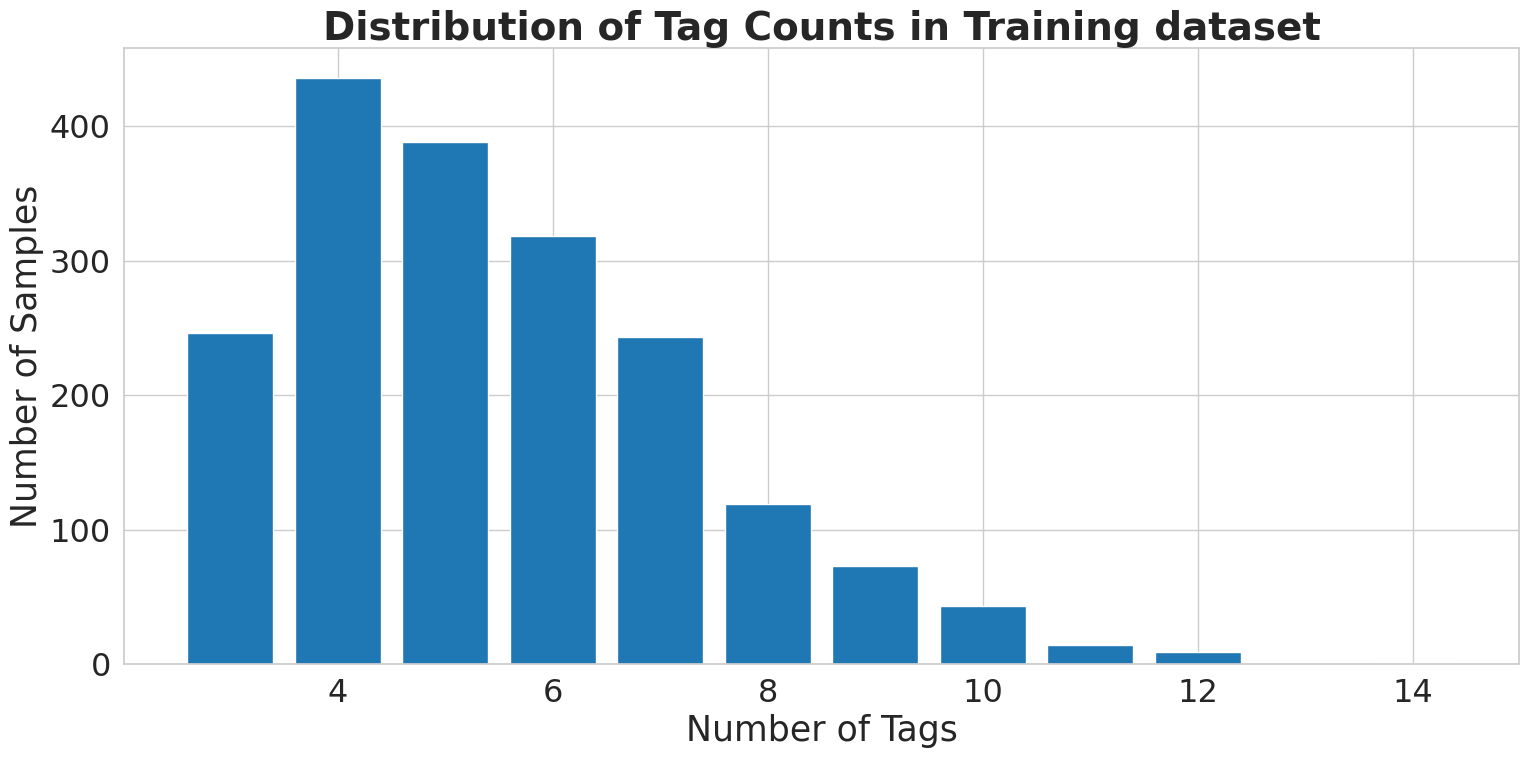

In [88]:
# calculate tag len distribution
tag_len_counts = df_train['aspect_list'].map(lambda x: len(x.split(', '))).value_counts().sort_index()
plt.bar(tag_len_counts.index, tag_len_counts.values)
plt.xlabel("Number of Tags")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tag Counts in Training dataset", fontweight='bold')
plt.savefig("../docs/assets/tag_count_distribution_musiccaps.pdf", bbox_inches='tight')
plt.show()

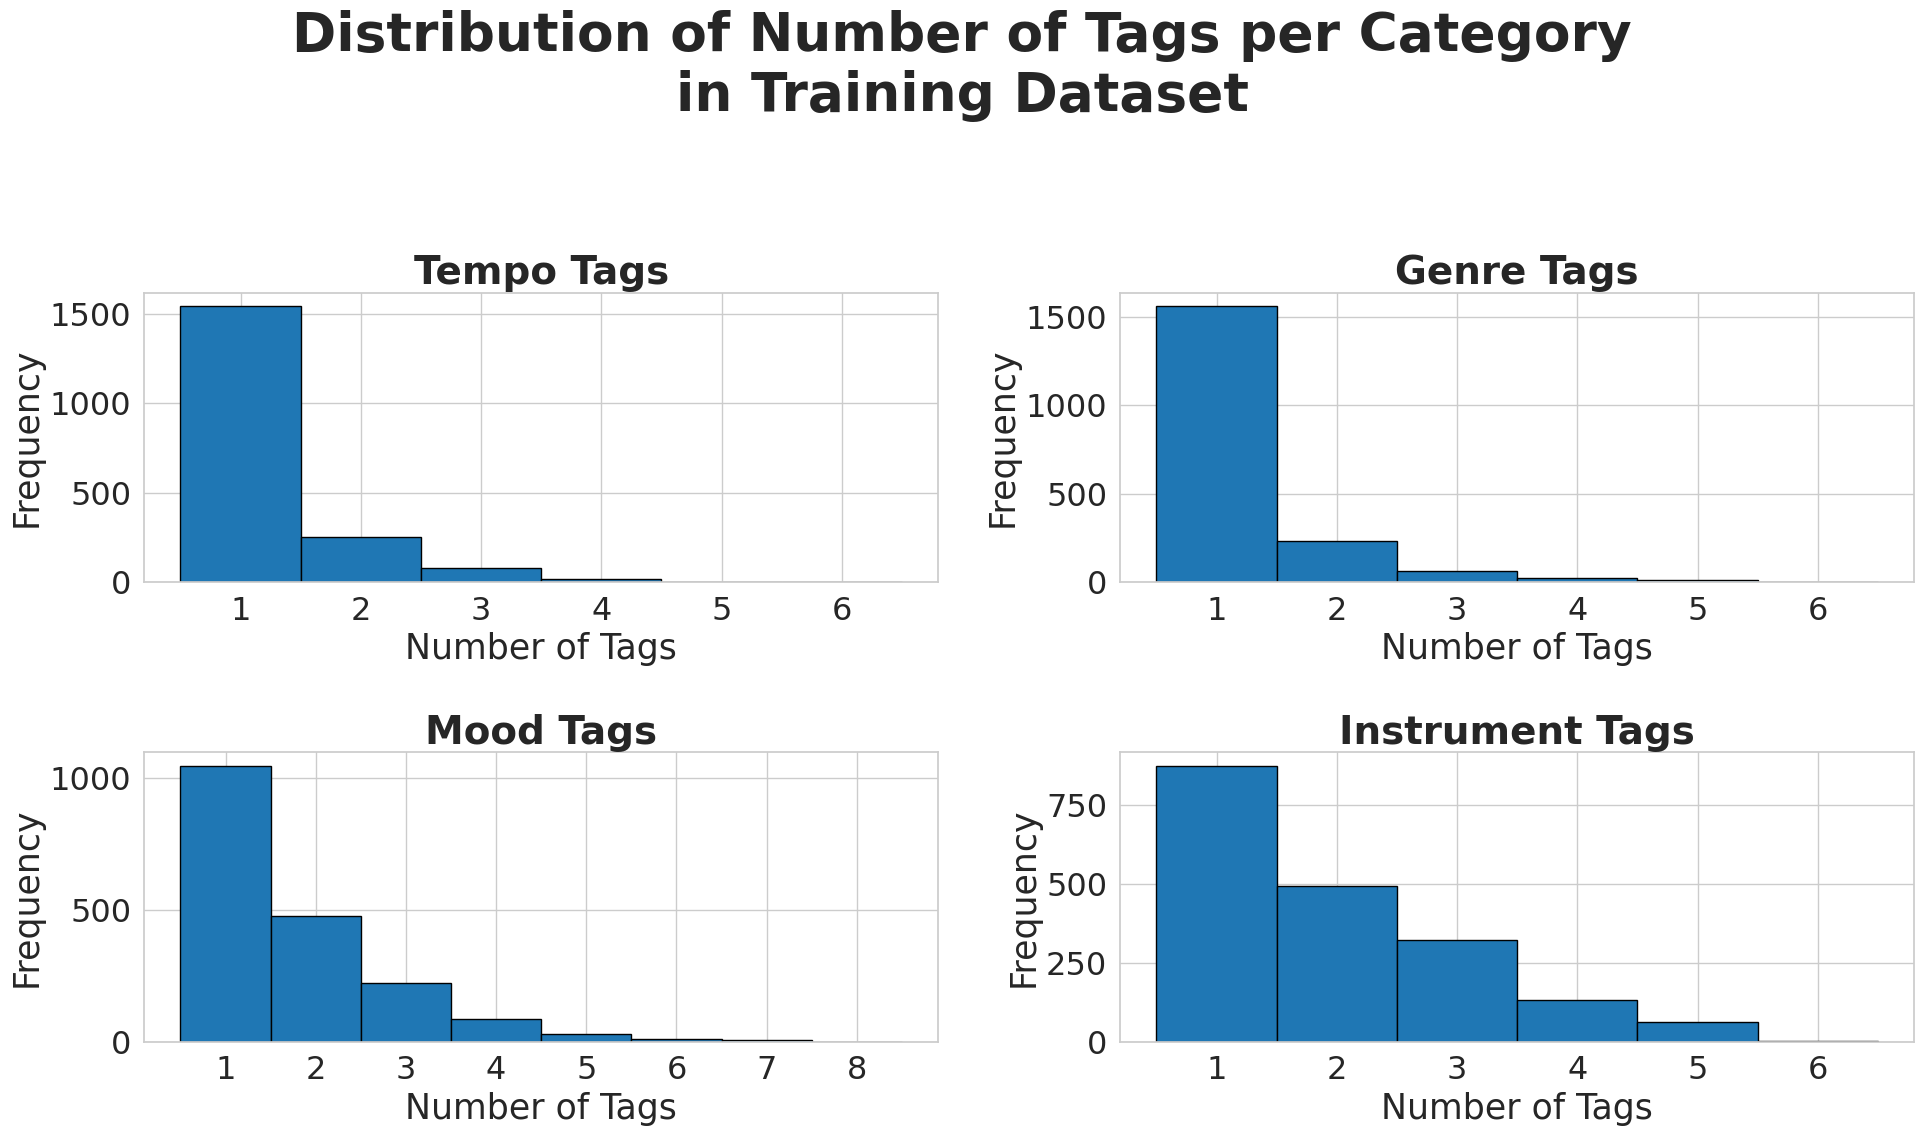

In [89]:
# Plot distribution of number of tags per category
tag_columns = ["tempo_tags", "genre_tags", "mood_tags", "instrument_tags"]
plt.figure(figsize=(20, 12))
titles = ['Tempo Tags', 'Genre Tags', 'Mood Tags', 'Instrument Tags']
for i, col in enumerate(tag_columns, 1):
    plt.subplot(2, 2, i)
    tag_counts = df_train[col].apply(lambda x: len(x.split(', ')))
    
    # Create histogram with centered bin labels
    n, bins, patches = plt.hist(tag_counts, bins=range(1, tag_counts.max() + 2), edgecolor='black')
    bin_centers = (bins[:-1] + bins[1:]) / 2
    plt.xticks(bin_centers, [int(x) for x in bin_centers], rotation=0)
    
    plt.title(titles[i-1], fontweight='bold')
    plt.xlabel('Number of Tags')
    plt.ylabel('Frequency')
plt.suptitle('Distribution of Number of Tags per Category\nin Training Dataset', fontweight='bold')
plt.tight_layout(rect=[0, 0.01, 1, 0.95])
plt.savefig("../docs/assets/tag_count_distribution_per_category.pdf")
plt.show()

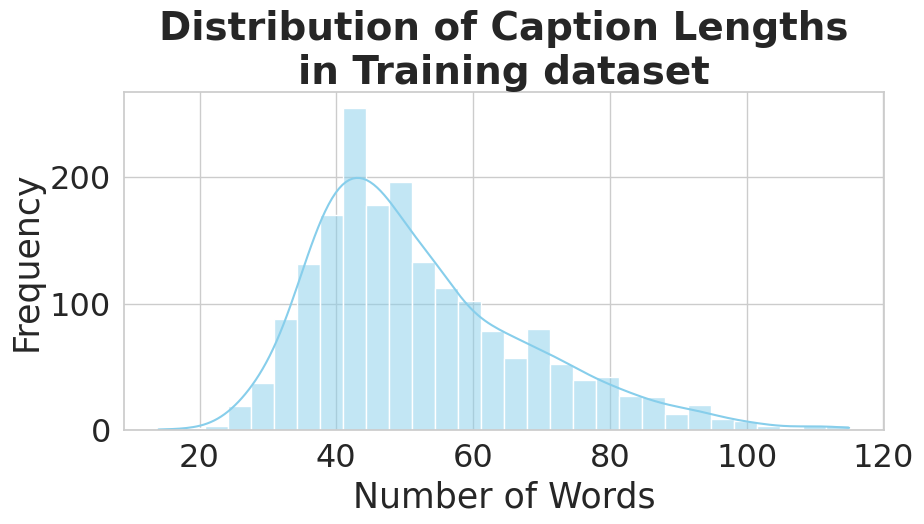

In [90]:
# Display distribution of caption lengths
df_train['caption_length'] = df_train['caption'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df_train['caption_length'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Caption Lengths\nin Training dataset', fontweight='bold')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("../docs/assets/caption_length_distribution_musiccaps.pdf", bbox_inches='tight')
plt.show()

## Save final dataset

In [91]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_train, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [ ]:
# Create output directory
output_dir = Path("../data/distilled-musiccaps")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [ ]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/distilled-musiccaps", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption/commit/df37b6c01caddbbc02941f4a7d1f76761425aae1', commit_message='Upload dataset', commit_description='', oid='df37b6c01caddbbc02941f4a7d1f76761425aae1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/musiccaps-tags-to-caption', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/musiccaps-tags-to-caption'), pr_revision=None, pr_num=None)